# Import Librairies

In [6]:
import requests
import pandas as pd
from io import StringIO
import numpy as np


from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

import joblib
import optuna
from xgboost import XGBRegressor


from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.style.use('ggplot')

# Creation of dataset

Our data processing pipeline is designed to predict future water levels (6 hours forecasting) using precipitation data, river discharge and water levels for the past 100 hours. This approach allows the model to leverage both historical trends and future predictions to improve accuracy in water level forecasting.

## Get data


In [7]:


def get_data(start_date, end_date, latitude=45.74421529397453, longitude=-0.6310521519322879):
    # URL for Open-Meteo data
    url_weather = (
        f"https://archive-api.open-meteo.com/v1/archive?latitude={latitude}&longitude={longitude}"
        f"&start_date={start_date}&end_date={end_date}&hourly=temperature_2m,relative_humidity_2m,"
        f"wind_speed_10m,precipitation&timezone=Europe%2FParis"
    )

    url_hydro_forecast = (f"https://flood-api.open-meteo.com/v1/flood?latitude={latitude}&longitude={longitude}"
        f"&start_date={start_date}&end_date={end_date}&daily=river_discharge_mean&timezone=Europe%2FParis")
    

    # get weather data
    response_weather = requests.get(url_weather)
    if response_weather.status_code != 200:
        raise Exception(f"Erreur lors de la récupération des données météorologiques : {response_weather.status_code}")

    # weather data extraction
    data_weather = response_weather.json()
    timestamps = data_weather["hourly"]["time"]
    precipitations = data_weather["hourly"]["precipitation"]

    response_hydro = requests.get(url_hydro_forecast)
    if response_hydro.status_code != 200:
        raise Exception(f"Erreur lors de la récupération des données hydrologiques : {response_hydro.status_code}")
    
    data_hydro = response_hydro.json()
    timestamps_hydro = data_hydro["daily"]["time"]
    temperatures_hydro = data_hydro["daily"]["river_discharge_mean"]

    df_hydro2 = pd.DataFrame({
        "Date & Heure": timestamps_hydro,
        "discharge": temperatures_hydro
    })
    df_hydro2["Date & Heure"] = pd.to_datetime(df_hydro2["Date & Heure"])

    df_weather = pd.DataFrame({
        "Date & Heure": timestamps,
       
        "Précipitations (mm)": precipitations
    })

    df_weather["Date & Heure"] = pd.to_datetime(df_weather["Date & Heure"])

    with open('R520001001_H.csv', 'r') as file:
        csv_data = file.read()

    df_hydro = process_hydro_data(csv_data)
    df_hydro2["Date & Heure"] = pd.to_datetime(df_hydro2["Date & Heure"])
    df_hydro2 = df_hydro2.set_index("Date & Heure")

    df_hydro2 = df_hydro2.resample("h").ffill().reset_index()

    df_combined = pd.merge(df_weather, df_hydro, left_on="Date & Heure", right_on="Date (TU)", how="inner")
    df_combined = pd.merge(df_combined, df_hydro2, left_on="Date & Heure", right_on="Date & Heure", how="inner")

    return df_combined[[ "Précipitations (mm)", "Valeur (en m)", "discharge"]]

def process_hydro_data(csv_data):

    data = StringIO(csv_data)

    df_hydro = pd.read_csv(data, header=None, names=[
        "Date (TU)", "Valeur (en m)", "Statut", "Qualification", "Méthode", "Continuité"
    ])

    df_hydro["Date (TU)"] = pd.to_datetime(df_hydro["Date (TU)"], format='%Y-%m-%dT%H:%M:%S.%fZ', errors='coerce')

    df_hydro = df_hydro[["Date (TU)", "Valeur (en m)"]]

    return df_hydro



In [8]:
# example of usage
start_date = "2020-10-10"
end_date = "2025-01-01"
X_days = 5
df_combined = get_data(start_date, end_date)

# save dataframe as a CSV
df_combined.to_csv("combined_data.csv", index=False)

## Read data

In [9]:
df = pd.read_csv("combined_data.csv")
df.head()

,Précipitations (mm),Valeur (en m),discharge
0,0.0,2.44,NaN
1,0.0,2.42,NaN
2,0.0,2.44,NaN
3,0.0,2.42,NaN
4,0.0,2.41,NaN


In [10]:
df.describe()

,Précipitations (mm),Valeur (en m),discharge
count,14163.000000,14163.000000,5117.000000
mean,0.123018,2.732769,112.921212
std,0.507045,0.620013,101.198827
min,0.000000,1.850000,1.290000
25%,0.000000,2.400000,44.780000
50%,0.000000,2.520000,79.720000
75%,0.000000,2.800000,145.750000
max,15.400000,6.170000,743.080000


In [11]:
# separation of training and testing data
split_index = int(len(df) * 0.8)
df_train = df.iloc[:split_index]
df_test = df.iloc[split_index:]

# scaling of data
scaler = MinMaxScaler()
df_train_scaled = pd.DataFrame(scaler.fit_transform(df_train), columns=df.columns, index=df_train.index)
df_test_scaled = pd.DataFrame(scaler.transform(df_test), columns=df.columns, index=df_test.index)

scaler_target = MinMaxScaler()
scaler_target.fit(df_train[["Valeur (en m)"]])

# function to create time sequences
def create_sequences(data, target_column, window_size=100):
    X, y = [], []
    for i in range(len(data) - window_size - 6):
        X.append(data.iloc[i:i + window_size].values)
        y.append(data.iloc[6 + i + window_size][target_column])
    return np.array(X), np.array(y)

# creation of sequences for training and testing
X_train, y_train = create_sequences(df_train_scaled, target_column="Valeur (en m)", window_size=100)
X_test, y_test = create_sequences(df_test_scaled, target_column="Valeur (en m)", window_size=100)

print(f"Train: {X_train.shape[0]} échantillons, {X_train.shape[1]} pas de temps, {X_train.shape[2]} variables")
print(f"Test: {X_test.shape[0]} échantillons, {X_test.shape[1]} pas de temps, {X_test.shape[2]} variables")

# saving transformed data
np.save("X_train.npy", X_train)
np.save("y_train.npy", y_train)
np.save("X_test.npy", X_test)
np.save("y_test.npy", y_test)

Train: 11224 échantillons, 100 pas de temps, 3 variables
Test: 2727 échantillons, 100 pas de temps, 3 variables


In [12]:
# saving scaler so we can scale the same way the input data for our predictions

joblib.dump(scaler, "scaler_features.pkl")
joblib.dump(scaler_target, "scaler_target.pkl")

['scaler_target.pkl']

## Preprocess The Data & Build The Model

In [13]:
# get transformed data
X_train = np.load("X_train.npy")
y_train = np.load("y_train.npy")
X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")

# reshape for XGBoost
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


def train(n_trials):
    # define objective function for Optuna
    def objective(trial):
        # define hyperparameters to search
        param = {
            'objective': 'reg:squarederror',
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
            'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
            'verbosity': 0,
            'tree_method': 'gpu_hist',
        }

        # initialize XGBoost regressor with the suggested parameters
        xgb = XGBRegressor(**param)
        
        # fit the model on training data
        xgb.fit(X_train, y_train)
        
        # predict on the validation set
        y_pred = xgb.predict(X_test)
        
        r2 = r2_score(y_test, y_pred)
        return r2

    # hyperparameter optimization using Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)

    print("Best trial:")
    best_trial = study.best_trial
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    # use the best parameters to train the final model
    best_params = best_trial.params
    xgb_best = XGBRegressor(**best_params, tree_method='gpu_hist', eval_metric='logloss')   
    xgb_best.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=0)

    # make predictions on the test set
    y_pred_test = xgb_best.predict(X_test)

    # calculate RMSE on the test set
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    print("Test RMSE:", rmse_test)
    
    return xgb_best

## Train & Evaluation

In [14]:
model = train(50)
model.save_model("xgb_model.json") #we save the model to use it in the backend for prediction

[I 2025-02-16 10:56:17,011] A new study created in memory with name: no-name-be7fc7fc-7f43-4339-80e1-1e25980a5754
[I 2025-02-16 10:56:18,911] Trial 0 finished with value: 0.8914846119371289 and parameters: {'n_estimators': 788, 'max_depth': 9, 'learning_rate': 0.005917610585552656, 'subsample': 0.6021744495842613, 'colsample_bytree': 0.6749780114244831, 'reg_alpha': 5.681557120567682, 'reg_lambda': 7.324651456016555}. Best is trial 0 with value: 0.8914846119371289.
[I 2025-02-16 10:56:19,547] Trial 1 finished with value: 0.8909953306872911 and parameters: {'n_estimators': 661, 'max_depth': 10, 'learning_rate': 0.09539457452478976, 'subsample': 0.9559197574196785, 'colsample_bytree': 0.73655666251962, 'reg_alpha': 6.101406877177049, 'reg_lambda': 8.750794198561545}. Best is trial 0 with value: 0.8914846119371289.
[I 2025-02-16 10:56:20,646] Trial 2 finished with value: 0.8980368994371658 and parameters: {'n_estimators': 1552, 'max_depth': 9, 'learning_rate': 0.07805402402021175, 'subsam

Best trial:
  Value: 0.9387856735775114
  Params: 
    n_estimators: 214
    max_depth: 3
    learning_rate: 0.0748596496387641
    subsample: 0.6304111238078056
    colsample_bytree: 0.9780632248371928
    reg_alpha: 1.1438289149720848
    reg_lambda: 3.9805924242702337
Test RMSE: 0.05356373777164766


/root/anaconda3/envs/nathan_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [10:56:53] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


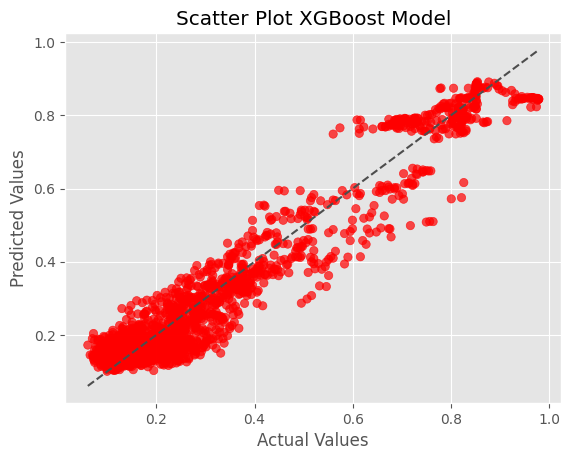

In [15]:
# we plot predicted values in function of real values and compare it to the identity

pred = model.predict(X_test)
plt.scatter(y_test, pred, alpha=0.7, label='Real', c=['red' for _ in range(len(y_test))])
plt.plot([y_test.min(), y_test.max()],
[y_test.min(), y_test.max()], '--', c='.3')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot XGBoost Model')
plt.show()

Text(0.5, 1.0, 'Real vs predicted water level in function of time')

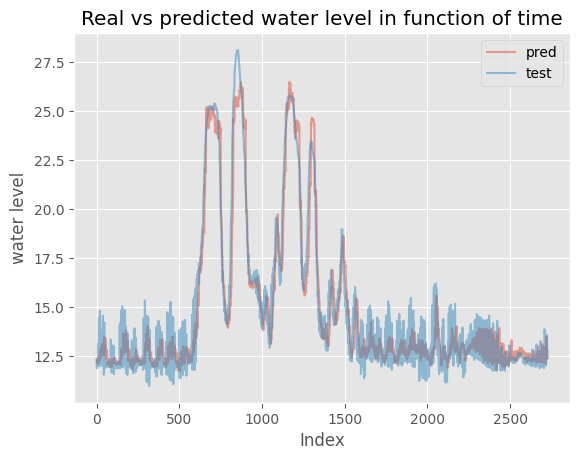

In [19]:
# we plot normalised real and predicted water levels

plt.plot(np.arange(len(pred)),pred,alpha=0.5,label='pred')
plt.plot(np.arange(len(pred)),y_test,alpha=0.5,label='test')
plt.legend()
plt.xlabel("Index")
plt.ylabel("water level")
plt.title("Real vs predicted water level in function of time")

MAE Globale: 0.7281316107822329


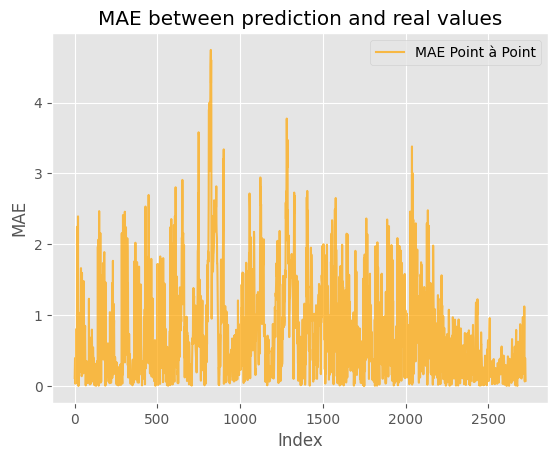

In [18]:
# inverse normalisation
pred = scaler_target.inverse_transform(pred.reshape(-1, 1)).flatten()
y_test = scaler_target.inverse_transform(y_test.reshape(-1, 1)).flatten()



# computing MAE
mae_series = np.abs(pred - y_test)
mae_value = mean_absolute_error(y_test, pred)
print(f"MAE Globale: {mae_value}")

# visualization of MAE at each point
plt.plot(np.arange(len(mae_series)), mae_series, label='MAE Point à Point', color='orange', alpha=0.7)
plt.xlabel("Index")
plt.ylabel("MAE")
plt.title("MAE between prediction and real values")
plt.legend()
plt.show()